# Fashion MNIST: Loading & Preprocessing Data

In [1]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
from torchvision.models import alexnet, AlexNet_Weights,mobilenet_v3_small,MobileNet_V3_Small_Weights, inception_v3, Inception_V3_Weights, vgg11, VGG11_Weights, resnet18,ResNet18_Weights
from torchvision.transforms import v2
import torch.optim as optim
from torch.optim import lr_scheduler
import os
from tempfile import TemporaryDirectory

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class TensorBoardLogger:
    def __init__(self, log_dir):
        self.summary_writer = SummaryWriter(log_dir)

    def add_scalars(self, tag_step_value_dict):
        """
        :param parent_tag: str, e.g. "Training Loss"
        :param tag_step_value_dict: dict, e.g., {"key":(step, value), "q_grad":(10000, 1.11)}
        """
        for tag, (step, value) in tag_step_value_dict.items():
            self.summary_writer.add_scalar(tag, value, step)

In [3]:
%load_ext tensorboard

## Train, Validation, Test datasets

In [4]:
import torch.utils
import torch.utils.data


train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))

seed = torch.Generator().manual_seed(42)
train_portion = 0.9
test_portion = 0.1

print(len(train_set))

train_set, valid_set = torch.utils.data.random_split(train_set,[train_portion,test_portion], seed)



test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

60000


In [5]:
#Create Dataset Class
class FashionMNISTDataset(Dataset):
    def __init__(self,data) -> None:
        super().__init__() 

        #construct attributes for the features and labels in the dataset
        x = []
        y = []

        for i in range(len(data)):
            x.append(data[i][0])
            y.append(data[i][1])

        

        self.x = torch.stack(x)
        self.y = torch.Tensor(y)
        self.y = self.y.type(dtype=torch.LongTensor)

    def __getitem__(self, index):
        image = self.x[index]
        label = self.y[index]

        return image, label

    def __len__(self):
        return len(self.x)

In [6]:
train_dataset = FashionMNISTDataset(train_set)
valid_dataset = FashionMNISTDataset(valid_set)
test_dataset = FashionMNISTDataset(test_set)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=100)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=100)

dataloaders = {"train" : [train_loader,len(train_dataset)],
               "valid" : [valid_loader,len(valid_dataset)],
               "test" : [test_loader,len(test_loader)]

}

In [10]:
train_dataset[0]

torch.Size([1, 28, 28])

In [7]:
fashion_mnist_labels = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }

In [8]:
labels_size = len(fashion_mnist_labels.keys())

In [9]:
def imshow(inp, normalized_image : str = False, title=None):
    """Display image for Tensor."""
    #inp = inp.numpy().transpose((-1,1, 2, 0))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    if not normalized_image:
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

torch.Size([10, 1, 28, 28])
torch.Size([3, 62, 242])
['Ankle Boot', 'Pullover', 'Sandal', 'T-shirt/Top', 'Sandal', 'Trouser', 'Dress', 'Sandal', 'T-shirt/Top', 'Trouser']


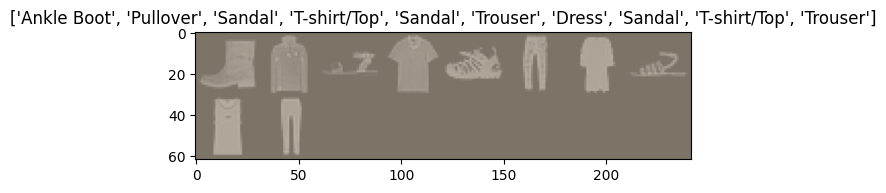

In [10]:
# Get a batch of training data

demo_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=10)
batch = next(iter(demo_loader))
images, labels = batch

print(images.shape)
# Make a grid from batch
out = torchvision.utils.make_grid(images)
print(out.shape)

title = [fashion_mnist_labels[int(x)] for x in labels]
print(title)
imshow(out, title=title)

In [11]:
dataloaders["valid"][1]

6000

In [11]:
def model_params_mode(model,mode : str):
    """
    This functino freezes/unfreezes model parameters depending on the desired input
    """
    if mode == "freeze":
        grad = False
    else:
        grad = True

    for param in model.parameters():
            param.requires_grad = grad



In [12]:
def update_model(model,out_dim : int, model_name : str):
    """
    This function modifies the model architecture to be compatible with the fashion MNIST output layer
    """

    

    if model_name == "AlexNet":
        in_features = model.classifier[1].in_features

        model.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(in_features,out_dim),
        nn.Softmax(dim=-1)
    )


    elif model_name == "VGG":
        in_features =  model.classifier[0].in_features


        model.classifier = nn.Sequential(
            nn.Linear(in_features,out_dim),
            nn.Softmax(dim=-1)
        )

    elif model_name == "MobileNet":
        in_features = model.classifier[3].in_features

        model.classifier[3] = nn.Sequential(
            nn.Linear(in_features,out_dim),
            nn.Softmax(dim=-1)
        )

    elif model_name == "InceptionV3":
        in_features = model.fc.in_features

        model.fc = nn.Sequential(
            nn.Linear(in_features,out_dim),
            nn.Softmax(dim=-1)
        )
    

    return model



In [14]:
class Model(nn.Module):
    def __init__(self, base_model,neurons : list,base_model_name : str = None) -> None:
        super().__init__()
        self.base_model = base_model
        self.base_model_name = base_model_name
        self.neurons = neurons
        self.replaceOutputLayer()
        

    def replaceOutputLayer(self):
        for param in self.base_model.parameters():
            param.requires_grad = False

        last_layer = None
        if self.base_model_name == "AlexNet": 

            old_out_features = self.base_model.classifier[6].out_features
            #self.base_model.classifier = nn.Linear(old_in_features,self.neurons[1])
            
        self.out_layer_1 = nn.Linear(old_out_features,self.neurons[1])



    def forward(self,x):
        x = self.base_model(x)
        return self.out_layer_1(x)



In [13]:
transform_im = v2.Compose([
    v2.Resize(size=(299,299)),
    #v2.RandomResizedCrop(size=(299, 299), antialias=True),
    #v2.RandomHorizontalFlip(p=0.5),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 1, 28, 28])
torch.Size([10, 3, 299, 299])
torch.Size([3, 604, 2410])


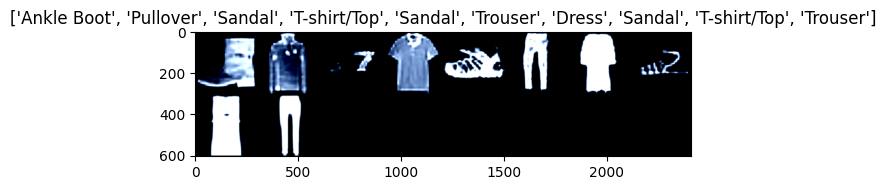

In [14]:
demo_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=10)
batch = next(iter(demo_loader))
images, labels = batch
print(images.shape)
images = transform_im(images)
print(images.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(images)
print(out.shape)

title = [fashion_mnist_labels[int(x)] for x in labels]

imshow(out,True, title=title)

In [15]:
def train_model(model, criterion, optimizer,dataloaders,weight_dir,logger : TensorBoardLogger,scheduler = None, num_epochs=25,debug = False):
        since = time.time()

   
        os.makedirs(weight_dir, exist_ok=True)
        best_model_params_path = os.path.join(weight_dir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        log_vars = {}
        

        for epoch in range(num_epochs):

            log_vars.update({
                "learning_rate" : (epoch,scheduler.get_last_lr()[0] if scheduler else optimizer.param_groups[0]['lr'])
            }
            )


            if debug:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase][0]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(transform_im(inputs))

                        outputs = outputs[0] if isinstance(outputs, torchvision.models.inception.InceptionOutputs) else outputs
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                if phase == 'train' and scheduler:
                    scheduler.step()

                epoch_loss = running_loss / dataloaders[phase][1]
                epoch_acc = running_corrects.double() / dataloaders[phase][1]

                if debug:
                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}\n')

                # deep copy the model
                if phase == 'valid' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

                log_vars.update(
                    {f"{phase}/Loss" : (epoch,epoch_loss),
                                      f"{phase}/Accuracy" : (epoch,epoch_acc.cpu().numpy())
                    }
                )
                
                logger.add_scalars(log_vars)
        

        time_elapsed = time.time() - since
        if debug:
            print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
            print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
        return model

In [16]:
def test_model(model,logger : TensorBoardLogger):
    model.eval()

    log_vars = {}

    tot_accurate_pred = 0


    for i,(image,labels) in enumerate(dataloaders["test"][0]):
        image,labels = image.to(device),labels.to(device)

        #predictions...
        with torch.no_grad():
            predictions = model(transform_im(image))
            _,predictions = torch.max(predictions,dim=-1)
            accurate_pred = torch.sum(predictions == labels.data)


        log_vars.update(
            {
                "Test/Accuracy_Batch" : (i, accurate_pred.double().cpu().numpy() / image.shape[0])
            }
        )

        logger.add_scalars(log_vars)

        tot_accurate_pred += accurate_pred.double().cpu().numpy()

    logger.add_scalars(
            {
                "Test/Accuracy_Tot" : (0, tot_accurate_pred / dataloaders["test"][1])
            }
        )
    

    





# AlexNet for Image Classification : Fashion MNIST

In [17]:
alexnet_model = alexnet(AlexNet_Weights.DEFAULT)

c:\Users\kevin\miniconda3\envs\neural_sys_fashion_mnist\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [18]:
alexnet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [19]:
model_params_mode(alexnet_model,"freeze")
alexnet_model = update_model(alexnet_model,labels_size,"AlexNet")

In [20]:
alexnet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=10, bias=True)
   

In [23]:
demo_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=10)
batch = next(iter(demo_loader))
images, labels = batch
inputs = transform_im(images)
with torch.no_grad():
    inputs,labels = inputs.to(device), labels.to(device)
    alexnet_model.to(device)
    alexnet_model.eval()
    outputs = alexnet_model(inputs)
outputs

tensor([[0.1163, 0.0628, 0.1242, 0.1029, 0.0649, 0.1138, 0.0786, 0.1592, 0.0943,
         0.0830],
        [0.0915, 0.0642, 0.1396, 0.1226, 0.0942, 0.1493, 0.0719, 0.1222, 0.0876,
         0.0569],
        [0.1092, 0.0975, 0.1229, 0.1073, 0.0964, 0.1152, 0.0904, 0.0940, 0.0920,
         0.0752],
        [0.0731, 0.0940, 0.1504, 0.0979, 0.1120, 0.1246, 0.0605, 0.0968, 0.1305,
         0.0602],
        [0.1345, 0.0813, 0.1135, 0.0990, 0.0717, 0.1215, 0.0435, 0.0998, 0.1386,
         0.0965],
        [0.0920, 0.0556, 0.1147, 0.1343, 0.0811, 0.2155, 0.0642, 0.0996, 0.0936,
         0.0495],
        [0.0503, 0.0906, 0.1836, 0.1178, 0.0695, 0.1260, 0.0695, 0.0909, 0.1371,
         0.0646],
        [0.1673, 0.1098, 0.1031, 0.0976, 0.0803, 0.1122, 0.0489, 0.1231, 0.0824,
         0.0753],
        [0.0783, 0.0633, 0.1505, 0.0979, 0.1166, 0.1680, 0.0882, 0.0829, 0.0981,
         0.0562],
        [0.0840, 0.0510, 0.1255, 0.1296, 0.0805, 0.1913, 0.0665, 0.1009, 0.1052,
         0.0655]], device='c

## Training AlexNet for Image Classification : Fashion MNIST

In [21]:
alexnet_model= alexnet_model.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_alexnet = optim.Adam(alexnet_model.classifier.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs

exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_alexnet,0.8)
#lr_scheduler.StepLR(optimizer_alexnet, step_size=2, gamma=0.1)


In [22]:
dir = os.path.abspath(os.getcwd()) + "/model/AlexNet_FE/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/AlexNet_FE/"
os.makedirs(log_dir, exist_ok=True)
logger = TensorBoardLogger(log_dir)

In [23]:
alexnet_model = train_model(alexnet_model, criterion, optimizer_alexnet,
                         dataloaders,dir,logger, num_epochs=30,debug=True)

Epoch 0/29
----------


c:\Users\kevin\miniconda3\envs\neural_sys_fashion_mnist\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


train Loss: 1.7043 Acc: 0.8091

valid Loss: 1.6210 Acc: 0.8617

Epoch 1/29
----------
train Loss: 1.6060 Acc: 0.8769

valid Loss: 1.5958 Acc: 0.8825

Epoch 2/29
----------
train Loss: 1.5874 Acc: 0.8916

valid Loss: 1.5848 Acc: 0.8890

Epoch 3/29
----------
train Loss: 1.5771 Acc: 0.8998

valid Loss: 1.5787 Acc: 0.8950

Epoch 4/29
----------
train Loss: 1.5711 Acc: 0.9040

valid Loss: 1.5738 Acc: 0.8983

Epoch 5/29
----------
train Loss: 1.5672 Acc: 0.9063

valid Loss: 1.5707 Acc: 0.9010

Epoch 6/29
----------
train Loss: 1.5626 Acc: 0.9111

valid Loss: 1.5688 Acc: 0.8998

Epoch 7/29
----------
train Loss: 1.5590 Acc: 0.9141

valid Loss: 1.5658 Acc: 0.9042

Epoch 8/29
----------
train Loss: 1.5566 Acc: 0.9156

valid Loss: 1.5634 Acc: 0.9075

Epoch 9/29
----------
train Loss: 1.5551 Acc: 0.9172

valid Loss: 1.5633 Acc: 0.9058

Epoch 10/29
----------
train Loss: 1.5526 Acc: 0.9188

valid Loss: 1.5613 Acc: 0.9060

Epoch 11/29
----------
train Loss: 1.5511 Acc: 0.9194

valid Loss: 1.5603 A

In [24]:
#Test in AlexNet FeatureExtractor
#log_dir = os.path.abspath(os.getcwd()) + "/runs/AlexNet_FeatureExtractor_Test/"
#os.makedirs(log_dir, exist_ok=True)
#logger = TensorBoardLogger(log_dir)
test_model(alexnet_model,logger)

In [25]:
%tensorboard --logdir runs/

UsageError: Line magic function `%tensorboard` not found.


## Fine-Tuning AlexNet for Image Classification : Fashion MNIST

In [ ]:
dir = os.path.abspath(os.getcwd()) + "/model/AlexNet_FineTune/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/AlexNet_FineTune/"
os.makedirs(log_dir, exist_ok=True)
logger = TensorBoardLogger(log_dir)

In [ ]:
model_params_mode(alexnet_model, "unfreeze")

optimizer_alexnet = optim.Adam(alexnet_model.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_alexnet, step_size=1, gamma=0.00001)

alexnet_model = train_model(alexnet_model, criterion, optimizer_alexnet,
                         dataloaders,dir,logger, num_epochs=10,debug=True)

Epoch 0/9
----------
train Loss: 1.5337 Acc: 0.9316

valid Loss: 1.5471 Acc: 0.9148

Epoch 1/9
----------
train Loss: 1.5288 Acc: 0.9357

valid Loss: 1.5448 Acc: 0.9180

Epoch 2/9
----------
train Loss: 1.5248 Acc: 0.9400

valid Loss: 1.5439 Acc: 0.9178

Epoch 3/9
----------
train Loss: 1.5223 Acc: 0.9416

valid Loss: 1.5418 Acc: 0.9208

Epoch 4/9
----------
train Loss: 1.5205 Acc: 0.9432

valid Loss: 1.5413 Acc: 0.9205

Epoch 5/9
----------
train Loss: 1.5190 Acc: 0.9451

valid Loss: 1.5413 Acc: 0.9193

Epoch 6/9
----------
train Loss: 1.5168 Acc: 0.9470

valid Loss: 1.5410 Acc: 0.9218

Epoch 7/9
----------
train Loss: 1.5145 Acc: 0.9493

valid Loss: 1.5397 Acc: 0.9208

Epoch 8/9
----------
train Loss: 1.5138 Acc: 0.9503

valid Loss: 1.5392 Acc: 0.9225

Epoch 9/9
----------
train Loss: 1.5118 Acc: 0.9524

valid Loss: 1.5378 Acc: 0.9248

Training complete in 81m 36s
Best val Acc: 0.924833


## Test AlexNet

In [28]:
dir = os.path.abspath(os.getcwd()) + "/model/AlexNet_FineTune/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/AlexNet_FineTune/"
logger = TensorBoardLogger(log_dir)

alexnet_model.load_state_dict(torch.load(dir + 'best_model_params.pt'))

<All keys matched successfully>

In [29]:
test_model(alexnet_model,logger)

# VGG16 for Image Classification : Fashion MNIST

In [30]:
vgg_model = vgg11(VGG11_Weights.DEFAULT)

c:\Users\kevin\miniconda3\envs\neural_sys_fashion_mnist\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [31]:
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [32]:
model_params_mode(vgg_model,"freeze")
vgg_model = update_model(vgg_model,labels_size,"VGG")

## Training VGG16 for Image Classification : Fashion MNIST

In [35]:
vgg_model= vgg_model.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_vggnet = optim.Adam(vgg_model.classifier.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs

exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_vggnet,0.8)

In [ ]:
dir = os.path.abspath(os.getcwd()) + "/model/VGG_FE/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/VGG_FE/"
os.makedirs(log_dir, exist_ok=True)
logger = TensorBoardLogger(log_dir)

In [ ]:
vgg_model = train_model(vgg_model, criterion, optimizer_vggnet,
                         dataloaders,dir,logger, num_epochs=30,debug=True)

Epoch 0/29
----------
train Loss: 1.6556 Acc: 0.8509

valid Loss: 1.5888 Acc: 0.8947

Epoch 1/29
----------
train Loss: 1.5704 Acc: 0.9108

valid Loss: 1.5686 Acc: 0.9078

Epoch 2/29
----------
train Loss: 1.5531 Acc: 0.9246

valid Loss: 1.5593 Acc: 0.9152

Epoch 3/29
----------
train Loss: 1.5428 Acc: 0.9333

valid Loss: 1.5536 Acc: 0.9190

Epoch 4/29
----------
train Loss: 1.5354 Acc: 0.9398

valid Loss: 1.5498 Acc: 0.9215

Epoch 5/29
----------
train Loss: 1.5297 Acc: 0.9452

valid Loss: 1.5470 Acc: 0.9232

Epoch 6/29
----------
train Loss: 1.5250 Acc: 0.9490

valid Loss: 1.5449 Acc: 0.9257

Epoch 7/29
----------
train Loss: 1.5209 Acc: 0.9524

valid Loss: 1.5433 Acc: 0.9272

Epoch 8/29
----------
train Loss: 1.5173 Acc: 0.9558

valid Loss: 1.5420 Acc: 0.9278

Epoch 9/29
----------
train Loss: 1.5142 Acc: 0.9586

valid Loss: 1.5410 Acc: 0.9285

Epoch 10/29
----------
train Loss: 1.5115 Acc: 0.9610

valid Loss: 1.5402 Acc: 0.9282

Epoch 11/29
----------
train Loss: 1.5090 Acc: 0.9631

## Fine-Tuning VGG16 for Image Classification : Fashion MNIST

In [ ]:
dir = os.path.abspath(os.getcwd()) + "/model/VGGNet_FineTune/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/VGGNet_FineTune/"
os.makedirs(log_dir, exist_ok=True)
logger = TensorBoardLogger(log_dir)

In [ ]:
model_params_mode(vgg_model, "unfreeze")


optimizer_vgg = optim.Adam(vgg_model.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_mobilenet_v3, step_size=1, gamma=0.1)

vgg_model = train_model(vgg_model, criterion, optimizer_vgg,
                         dataloaders,dir,logger, num_epochs=10,debug=True)

## test VGG16

In [36]:
dir = os.path.abspath(os.getcwd()) + "/model/VGG_FE/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/VGG_FE/"
logger = TensorBoardLogger(log_dir)

vgg_model.load_state_dict(torch.load(dir + 'best_model_params.pt'))

<All keys matched successfully>

In [37]:
test_model(vgg_model,logger)

c:\Users\kevin\miniconda3\envs\neural_sys_fashion_mnist\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


# Inception V3 for Image Classification : Fashion MNIST

In [38]:
inception_v3_model = inception_v3(Inception_V3_Weights.DEFAULT)

In [39]:
inception_v3_model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [40]:
model_params_mode(inception_v3_model,"freeze")
inception_v3_model = update_model(inception_v3_model,labels_size,"InceptionV3")

## Training Inception V3 for Image Classification : Fashion MNIST

In [41]:
inception_v3_model= inception_v3_model.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_inception_v3 = optim.Adam(inception_v3_model.fc.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs

exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_inception_v3,0.8)
#lr_scheduler.StepLR(optimizer_alexnet, step_size=2, gamma=0.1)

In [42]:
dir = os.path.abspath(os.getcwd()) + "/model/InceptionV3_FE/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/InceptionV3_FE/"
os.makedirs(log_dir, exist_ok=True)
logger = TensorBoardLogger(log_dir)

In [43]:
inception_v3_model = train_model(inception_v3_model, criterion, optimizer_inception_v3,
                         dataloaders,dir,logger, num_epochs=30,debug=True)

Epoch 0/29
----------
train Loss: 2.0908 Acc: 0.5412

valid Loss: 1.9150 Acc: 0.7307

Epoch 1/29
----------
train Loss: 1.8641 Acc: 0.7244

valid Loss: 1.8147 Acc: 0.7463

Epoch 2/29
----------
train Loss: 1.8056 Acc: 0.7370

valid Loss: 1.7779 Acc: 0.7532

Epoch 3/29
----------
train Loss: 1.7789 Acc: 0.7445

valid Loss: 1.7579 Acc: 0.7588

Epoch 4/29
----------
train Loss: 1.7627 Acc: 0.7485

valid Loss: 1.7447 Acc: 0.7617

Epoch 5/29
----------
train Loss: 1.7520 Acc: 0.7535

valid Loss: 1.7350 Acc: 0.7650

Epoch 6/29
----------
train Loss: 1.7427 Acc: 0.7582

valid Loss: 1.7230 Acc: 0.7765

Epoch 7/29
----------
train Loss: 1.7301 Acc: 0.7715

valid Loss: 1.7117 Acc: 0.7860

Epoch 8/29
----------
train Loss: 1.7212 Acc: 0.7785

valid Loss: 1.7032 Acc: 0.7907

Epoch 9/29
----------
train Loss: 1.7140 Acc: 0.7824

valid Loss: 1.6976 Acc: 0.7980

Epoch 10/29
----------
train Loss: 1.7087 Acc: 0.7852

valid Loss: 1.6926 Acc: 0.8007

Epoch 11/29
----------
train Loss: 1.7051 Acc: 0.7870

## Test InceptionV3

In [44]:
dir = os.path.abspath(os.getcwd()) + "/model/InceptionV3_FE/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/InceptionV3_FE/"
logger = TensorBoardLogger(log_dir)

inception_v3_model.load_state_dict(torch.load(dir + 'best_model_params.pt'))

<All keys matched successfully>

In [45]:
test_model(inception_v3_model,logger)

# MobileNet V3 for Image Classification : Fashion MNIST

In [31]:
mobilenet_v3_small_model = mobilenet_v3_small(MobileNet_V3_Small_Weights.DEFAULT)

In [55]:
mobilenet_v3_small_model.features[12:]

Sequential(
  (12): Conv2dNormActivation(
    (0): Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(576, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
)

In [56]:
mobilenet_v3_small_model.classifier

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)

In [32]:
model_params_mode(mobilenet_v3_small_model,"freeze")
mobilenet_v3_small_model = update_model(mobilenet_v3_small_model,labels_size,"MobileNet")

In [ ]:
mobilenet_v3_small_model.classifier

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Sequential(
    (0): Linear(in_features=1024, out_features=10, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Training MobileNet V3 for Image Classification : Fashion MNIST

In [36]:
mobilenet_v3_small_model= mobilenet_v3_small_model.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_mobilenet_v3 = optim.Adam(mobilenet_v3_small_model.classifier[3].parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs

exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_mobilenet_v3,0.8)
#lr_scheduler.StepLR(optimizer_alexnet, step_size=2, gamma=0.1)

In [ ]:
dir = os.path.abspath(os.getcwd()) + "/model/MobileNet_FE/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/MobileNet_FE/"
os.makedirs(log_dir, exist_ok=True)
logger = TensorBoardLogger(log_dir)

In [ ]:
mobilenet_v3_small_model = train_model(mobilenet_v3_small_model, criterion, optimizer_mobilenet_v3,
                         dataloaders,dir,logger, num_epochs=30,debug=True)

Epoch 0/29
----------
train Loss: 2.0676 Acc: 0.6006

valid Loss: 1.9861 Acc: 0.7263

Epoch 1/29
----------
train Loss: 1.8265 Acc: 0.7660

valid Loss: 1.7812 Acc: 0.7765

Epoch 2/29
----------
train Loss: 1.7581 Acc: 0.7864

valid Loss: 1.7386 Acc: 0.7927

Epoch 3/29
----------
train Loss: 1.7262 Acc: 0.7993

valid Loss: 1.7143 Acc: 0.8027

Epoch 4/29
----------
train Loss: 1.7060 Acc: 0.8089

valid Loss: 1.6981 Acc: 0.8123

Epoch 5/29
----------
train Loss: 1.6922 Acc: 0.8161

valid Loss: 1.6863 Acc: 0.8178

Epoch 6/29
----------
train Loss: 1.6815 Acc: 0.8224

valid Loss: 1.6773 Acc: 0.8232

Epoch 7/29
----------
train Loss: 1.6730 Acc: 0.8281

valid Loss: 1.6701 Acc: 0.8272

Epoch 8/29
----------
train Loss: 1.6659 Acc: 0.8316

valid Loss: 1.6642 Acc: 0.8295

Epoch 9/29
----------
train Loss: 1.6606 Acc: 0.8350

valid Loss: 1.6591 Acc: 0.8330

Epoch 10/29
----------
train Loss: 1.6561 Acc: 0.8376

valid Loss: 1.6550 Acc: 0.8355

Epoch 11/29
----------
train Loss: 1.6523 Acc: 0.8399

## Fine-Tuning MobileNet V3 for Image Classification : Fashion MNIST

In [ ]:
dir = os.path.abspath(os.getcwd()) + "/model/MobileNet_FineTune/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/MobileNet_FineTune/"
os.makedirs(log_dir, exist_ok=True)
logger = TensorBoardLogger(log_dir)

In [33]:
model_params_mode(mobilenet_v3_small_model, "unfreeze")

In [ ]:
model_params_mode(mobilenet_v3_small_model, "unfreeze")


optimizer_mobilenet_v3 = optim.Adam(mobilenet_v3_small_model.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_mobilenet_v3, step_size=1, gamma=0.1)

mobilenet_v3_small_model = train_model(mobilenet_v3_small_model, criterion, optimizer_mobilenet_v3,
                         dataloaders,dir,logger, num_epochs=10,debug=True)

## Test MobileNet V3

In [59]:
dir = os.path.abspath(os.getcwd()) + "/model/MobileNet_FE/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/MobileNet_FE/"
logger = TensorBoardLogger(log_dir)

mobilenet_v3_small_model.load_state_dict(torch.load(dir + 'best_model_params.pt'))

<All keys matched successfully>

In [60]:
test_model(mobilenet_v3_small_model,logger)

In [34]:
dir = os.path.abspath(os.getcwd()) + "/model/MobileNet_FineTune/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/MobileNet_FineTune/"
logger = TensorBoardLogger(log_dir)

mobilenet_v3_small_model.load_state_dict(torch.load(dir + 'best_model_params.pt'))

<All keys matched successfully>

In [37]:
test_model(mobilenet_v3_small_model,logger)

# Benchmark Model Comparison 

## Train vs Validation metrics

### Adjusting pretrained model to Fashion MNIST output layer

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import pandas as pd

In [181]:
# Nombre del worksheet que deseas leer (reemplaza "NombreHoja" con el nombre real)
worksheet_name = "FE"
pth = "./data.xlsx"

# Leer el archivo de Excel y seleccionar el worksheet específico
df = pd.read_excel(pth, sheet_name=worksheet_name,header=[0,1,2]).drop(["Unnamed: 0_level_0"],axis=1)

C:\Users\kevin\AppData\Local\Temp\ipykernel_16532\3340892132.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = pd.read_excel(pth, sheet_name=worksheet_name,header=[0,1,2]).drop(["Unnamed: 0_level_0"],axis=1)


In [182]:
df = df.rename(columns={'Accuracy.1' : "Accuracy",
                        "Loss.1" : "Loss",
                         'Accuracy.2' : "Accuracy",
                        "Loss.2" : "Loss",
                         'Accuracy.3' : "Accuracy",
                        "Loss.3" : "Loss" })

In [176]:
df.head()

Train                                                         \
  Alexnet_FE            VGG11_FE           InceptionV3_FE             
    Accuracy      Loss  Accuracy      Loss       Accuracy      Loss   
0   0.809130  1.704332  0.850944  1.655634       0.541222  2.090817   
1   0.876944  1.606044  0.910778  1.570397       0.724370  1.864092   
2   0.891593  1.587359  0.924593  1.553141       0.736982  1.805602   
3   0.899778  1.577132  0.933296  1.542808       0.744500  1.778916   
4   0.904037  1.571134  0.939778  1.535430       0.748463  1.762676   

                           Validation                                \
  MobileNetV3_FE           Alexnet_FE            VGG11_FE             
        Accuracy      Loss   Accuracy      Loss  Accuracy      Loss   
0       0.600630  2.067568   0.861667  1.621044  0.894667  1.588824   
1       0.765981  1.826494   0.861667  1.621044  0.894667  1.588824   
2       0.786389  1.758148   0.882500  1.595805  0.907833  1.568605   
3       0.799315  1.726168   0.882500  1.595805  0.907833  1.568605   
4       0.808944  1.706040   0.889000  1.584782  0.915167  1.559340   

                                                     
  InceptionV3_FE           MobileNetV3_FE            
        Accuracy      Loss       Accuracy      Loss  
0       0.730667  1.914983       0.726333  1.986104  
1       0.730667  1.914983       0.726333  1.986104  
2       0.746333  1.814681       0.776500  1.781153  
3       0.746333  1.814681       0.776500  1.781153  
4       0.753167  1.777853       0.792667  1.738636

In [177]:
subset =[("Validation","Alexnet_FE","Accuracy"),
                                ("Validation","Alexnet_FE","Loss"),
                                ("Validation","VGG11_FE","Accuracy"),
                                ("Validation","VGG11_FE","Loss"),
                                ("Validation","InceptionV3_FE","Accuracy"),
                                ("Validation","InceptionV3_FE","Loss"),
                                ("Validation","MobileNetV3_FE","Accuracy"),
                                ("Validation","MobileNetV3_FE","Loss"),
                                
                                ]

subset1 =[("Train","Alexnet_FE","Accuracy"),
                                ("Train","Alexnet_FE","Loss"),
                                ("Train","VGG11_FE","Accuracy"),
                                ("Train","VGG11_FE","Loss"),
                                ("Train","InceptionV3_FE","Accuracy"),
                                ("Train","InceptionV3_FE","Loss"),
                                ("Train","MobileNetV3_FE","Accuracy"),
                                ("Train","MobileNetV3_FE","Loss")]

In [183]:
df2 = df.drop_duplicates(subset=subset,keep="first").drop(columns=subset1).reset_index().drop(columns=["index"])

C:\Users\kevin\AppData\Local\Temp\ipykernel_16532\1147848402.py:17: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ("Train","MobileNetV3_FE","Loss")]).reset_index().drop(columns=["index"])


In [184]:
df2.shape

(30, 8)

In [185]:
df2.head(50)

Validation                                                         \
   Alexnet_FE            VGG11_FE           InceptionV3_FE             
     Accuracy      Loss  Accuracy      Loss       Accuracy      Loss   
0    0.861667  1.621044  0.894667  1.588824       0.730667  1.914983   
1    0.882500  1.595805  0.907833  1.568605       0.746333  1.814681   
2    0.889000  1.584782  0.915167  1.559340       0.753167  1.777853   
3    0.895000  1.578710  0.919000  1.553574       0.758833  1.757920   
4    0.898333  1.573811  0.921500  1.549772       0.761667  1.744695   
5    0.901000  1.570703  0.923167  1.547031       0.765000  1.735003   
6    0.899833  1.568795  0.925667  1.544921       0.776500  1.722953   
7    0.904167  1.565776  0.927167  1.543274       0.786000  1.711706   
8    0.907500  1.563397  0.927833  1.542043       0.790667  1.703204   
9    0.905833  1.563320  0.928500  1.541032       0.798000  1.697595   
10   0.906000  1.561319  0.928167  1.540238       0.800667  1.692577   
11   0.907667  1.560252  0.928833  1.539603       0.804500  1.687698   
12   0.908167  1.559319  0.929000  1.539054       0.803833  1.685169   
13   0.910833  1.558170  0.930000  1.538583       0.807833  1.681163   
14   0.907833  1.558210  0.930000  1.538248       0.809000  1.678675   
15   0.906833  1.558141  0.929333  1.537978       0.810500  1.676172   
16   0.908833  1.556746  0.930000  1.537706       0.813167  1.673365   
17   0.910500  1.555745  0.930667  1.537479       0.813167  1.672168   
18   0.911333  1.555583  0.930333  1.537265       0.815000  1.669894   
19   0.910500  1.555662  0.929500  1.537063       0.816167  1.667776   
20   0.911500  1.554618  0.929333  1.536814       0.816333  1.666372   
21   0.911667  1.554494  0.930500  1.536531       0.819167  1.664779   
22   0.913167  1.553482  0.930000  1.536287       0.818500  1.664020   
23   0.911667  1.553833  0.930000  1.536063       0.819333  1.662870   
24   0.911500  1.553509  0.929167  1.535825       0.819000  1.661223   
25   0.912000  1.552222  0.929500  1.535529       0.822167  1.659952   
26   0.912333  1.552736  0.929833  1.535295       0.819000  1.659264   
27   0.912833  1.552310  0.929667  1.535082       0.821167  1.657692   
28   0.914667  1.551306  0.929833  1.534890       0.822500  1.656866   
29   0.912667  1.551388  0.929333  1.534650       0.822833  1.656130   

                             
   MobileNetV3_FE            
         Accuracy      Loss  
0        0.726333  1.986104  
1        0.776500  1.781153  
2        0.792667  1.738636  
3        0.802667  1.714304  
4        0.812333  1.698113  
5        0.817833  1.686344  
6        0.823167  1.677337  
7        0.827167  1.670125  
8        0.829500  1.664221  
9        0.833000  1.659147  
10       0.835500  1.655046  
11       0.836333  1.651468  
12       0.839000  1.648196  
13       0.840667  1.645481  
14       0.841667  1.642845  
15       0.843833  1.640703  
16       0.845167  1.638683  
17       0.846000  1.636973  
18       0.847167  1.635222  
19       0.848000  1.633844  
20       0.849833  1.632232  
21       0.850333  1.631143  
22       0.851500  1.629857  
23       0.851833  1.628656  
24       0.852667  1.627653  
25       0.853500  1.626613  
26       0.853667  1.625745  
27       0.854333  1.624822  
28       0.854833  1.623874  
29       0.854167  1.623120

In [186]:
df.dropna(inplace=True)
df[subset] = df2

In [187]:
df.shape

(30, 16)

In [188]:
df.tail()

Train                                                         \
   Alexnet_FE            VGG11_FE           InceptionV3_FE             
     Accuracy      Loss  Accuracy      Loss       Accuracy      Loss   
25   0.929778  1.538483  0.977648  1.489354       0.802889  1.678558   
26   0.930630  1.537526  0.978167  1.488592       0.804130  1.676408   
27   0.931518  1.536747  0.978593  1.487876       0.803593  1.677017   
28   0.930111  1.537565  0.979167  1.487160       0.804222  1.674994   
29   0.932593  1.536098  0.979593  1.486463       0.806167  1.673907   

                            Validation                                \
   MobileNetV3_FE           Alexnet_FE            VGG11_FE             
         Accuracy      Loss   Accuracy      Loss  Accuracy      Loss   
25       0.857648  1.624699   0.912000  1.552222  0.929500  1.535529   
26       0.858704  1.622971   0.912333  1.552736  0.929833  1.535295   
27       0.859593  1.622090   0.912833  1.552310  0.929667  1.535082   
28       0.859130  1.621238   0.914667  1.551306  0.929833  1.534890   
29       0.860389  1.620370   0.912667  1.551388  0.929333  1.534650   

                                                      
   InceptionV3_FE           MobileNetV3_FE            
         Accuracy      Loss       Accuracy      Loss  
25       0.822167  1.659952       0.853500  1.626613  
26       0.819000  1.659264       0.853667  1.625745  
27       0.821167  1.657692       0.854333  1.624822  
28       0.822500  1.656866       0.854833  1.623874  
29       0.822833  1.656130       0.854167  1.623120

In [189]:
df.head(30)

Train                                                         \
   Alexnet_FE            VGG11_FE           InceptionV3_FE             
     Accuracy      Loss  Accuracy      Loss       Accuracy      Loss   
0    0.809130  1.704332  0.850944  1.655634       0.541222  2.090817   
1    0.876944  1.606044  0.910778  1.570397       0.724370  1.864092   
2    0.891593  1.587359  0.924593  1.553141       0.736982  1.805602   
3    0.899778  1.577132  0.933296  1.542808       0.744500  1.778916   
4    0.904037  1.571134  0.939778  1.535430       0.748463  1.762676   
5    0.906333  1.567173  0.945167  1.529690       0.753500  1.751982   
6    0.911148  1.562627  0.949000  1.524950       0.758204  1.742711   
7    0.914074  1.559034  0.952444  1.520884       0.771519  1.730143   
8    0.915593  1.556600  0.955778  1.517347       0.778500  1.721224   
9    0.917167  1.555140  0.958574  1.514247       0.782389  1.713950   
10   0.918833  1.552636  0.961037  1.511498       0.785185  1.708666   
11   0.919407  1.551143  0.963130  1.509026       0.786963  1.705083   
12   0.920944  1.549370  0.964870  1.506777       0.787463  1.702718   
13   0.922500  1.547856  0.966296  1.504735       0.790167  1.698766   
14   0.922463  1.547555  0.968093  1.502876       0.793648  1.695874   
15   0.923796  1.546167  0.969463  1.501133       0.794093  1.693526   
16   0.925222  1.544645  0.970648  1.499519       0.795741  1.690992   
17   0.925648  1.543933  0.971778  1.498042       0.795426  1.689505   
18   0.927074  1.542611  0.972870  1.496673       0.798000  1.687824   
19   0.926056  1.542567  0.973778  1.495403       0.797926  1.685709   
20   0.926259  1.542079  0.974481  1.494221       0.798074  1.684817   
21   0.928241  1.540771  0.975093  1.493108       0.798796  1.683672   
22   0.928667  1.540225  0.976000  1.492063       0.799685  1.682104   
23   0.929148  1.539602  0.976648  1.491094       0.802537  1.679958   
24   0.929907  1.538571  0.977204  1.490193       0.801741  1.679272   
25   0.929778  1.538483  0.977648  1.489354       0.802889  1.678558   
26   0.930630  1.537526  0.978167  1.488592       0.804130  1.676408   
27   0.931518  1.536747  0.978593  1.487876       0.803593  1.677017   
28   0.930111  1.537565  0.979167  1.487160       0.804222  1.674994   
29   0.932593  1.536098  0.979593  1.486463       0.806167  1.673907   

                            Validation                                \
   MobileNetV3_FE           Alexnet_FE            VGG11_FE             
         Accuracy      Loss   Accuracy      Loss  Accuracy      Loss   
0        0.600630  2.067568   0.861667  1.621044  0.894667  1.588824   
1        0.765981  1.826494   0.882500  1.595805  0.907833  1.568605   
2        0.786389  1.758148   0.889000  1.584782  0.915167  1.559340   
3        0.799315  1.726168   0.895000  1.578710  0.919000  1.553574   
4        0.808944  1.706040   0.898333  1.573811  0.921500  1.549772   
5        0.816111  1.692179   0.901000  1.570703  0.923167  1.547031   
6        0.822444  1.681465   0.899833  1.568795  0.925667  1.544921   
7        0.828093  1.673035   0.904167  1.565776  0.927167  1.543274   
8        0.831630  1.665931   0.907500  1.563397  0.927833  1.542043   
9        0.835019  1.660633   0.905833  1.563320  0.928500  1.541032   
10       0.837556  1.656079   0.906000  1.561319  0.928167  1.540238   
11       0.839889  1.652254   0.907667  1.560252  0.928833  1.539603   
12       0.843537  1.648185   0.908167  1.559319  0.929000  1.539054   
13       0.845167  1.645077   0.910833  1.558170  0.930000  1.538583   
14       0.846037  1.642255   0.907833  1.558210  0.930000  1.538248   
15       0.847815  1.640382   0.906833  1.558141  0.929333  1.537978   
16       0.849333  1.637828   0.908833  1.556746  0.930000  1.537706   
17       0.849741  1.635903   0.910500  1.555745  0.930667  1.537479   
18       0.851778  1.633410   0.911333  1.555583  0.930333  1.537265   
19       0.853000  1.631884   0.910500  1.55566

In [141]:
df.shape

(30, 16)

In [211]:
# Nombre del worksheet que deseas leer (reemplaza "NombreHoja" con el nombre real)
worksheet_name = "FineTune"
pth = "./data.xlsx"

# Leer el archivo de Excel y seleccionar el worksheet específico
df_worksheet_2 = pd.read_excel(pth, sheet_name=worksheet_name,header=[0,1,2]).drop(["Unnamed: 0_level_0"],axis=1)

C:\Users\kevin\AppData\Local\Temp\ipykernel_16532\1581877712.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_worksheet_2 = pd.read_excel(pth, sheet_name=worksheet_name,header=[0,1,2]).drop(["Unnamed: 0_level_0"],axis=1)


In [217]:
df_worksheet_2.shape

(11, 8)

In [215]:
subset =[("Train","Alexnet","Accuracy"),("Train","Alexnet","Loss"),
                                ("Train","MobileNetV3","Loss"),("Train","MobileNetV3","Accuracy"),
        ("Validation","Alexnet","Accuracy"),("Validation","Alexnet","Loss"),
                                ("Validation","MobileNetV3","Loss"),("Validation","MobileNetV3","Accuracy")                               
                                ]

In [216]:
df_worksheet_2.drop_duplicates(subset=subset,keep="first",inplace=True)

In [230]:
df_worksheet_2 = df_worksheet_2.reset_index().drop(["index"],axis=1).drop(df_worksheet_2.shape[0] - 1,axis=0)

C:\Users\kevin\AppData\Local\Temp\ipykernel_16532\702596300.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_worksheet_2 = df_worksheet_2.reset_index().drop(["index"],axis=1).drop(df_worksheet_2.shape[0] - 1,axis=0)


In [231]:
df_worksheet_2.head(20)

Train                                 Validation                        \
    Alexnet           MobileNetV3              Alexnet           MobileNetV3   
   Accuracy      Loss    Accuracy      Loss   Accuracy      Loss    Accuracy   
0  0.931556  1.533716    0.869018  1.605762   0.914833  1.547142    0.872000   
1  0.935667  1.528794    0.885278  1.586532   0.918000  1.544791    0.880167   
2  0.940000  1.524758    0.894093  1.575384   0.917833  1.543903    0.888833   
3  0.941593  1.522265    0.901611  1.567181   0.920833  1.541808    0.891333   
4  0.943222  1.520543    0.907463  1.560627   0.920500  1.541312    0.895667   
5  0.945130  1.518985    0.912537  1.555084   0.919333  1.541254    0.900167   
6  0.947019  1.516838    0.917278  1.550108   0.921833  1.540961    0.902833   
7  0.949259  1.514470    0.921111  1.545975   0.920833  1.539682    0.907500   
8  0.950259  1.513791    0.925241  1.542239   0.922500  1.539227    0.909167   
9  0.952370  1.511839    0.927722  1.539032   0.924833  1.537849    0.911500   

             
             
       Loss  
0  1.599344  
1  1.588602  
2  1.580604  
3  1.574230  
4  1.569624  
5  1.565744  
6  1.561872  
7  1.558601  
8  1.557163  
9  1.554429

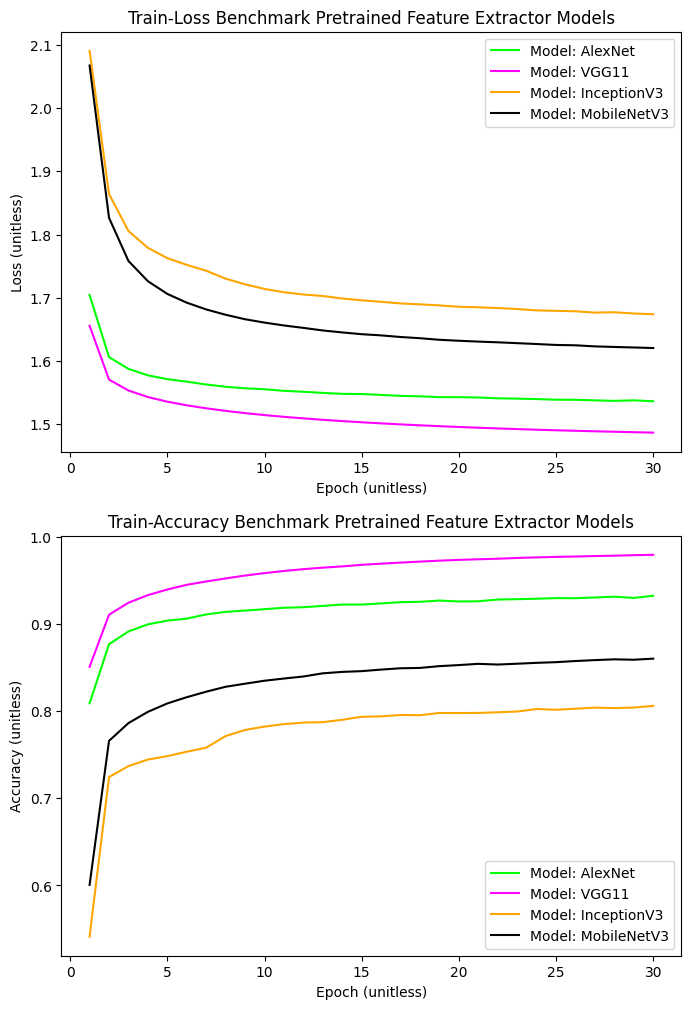

In [234]:
fig, ax = plt.subplots(2,1, figsize=(8, 12))
color1 = mcolors.CSS4_COLORS["lime"]
color2 = mcolors.CSS4_COLORS["magenta"]
color3 = mcolors.CSS4_COLORS["orange"]
color4 = mcolors.CSS4_COLORS["black"]

custom_ylim = (1.3,2.1)
custom_xlim = (1,30)

#plt.setp(ax,  ylim=custom_ylim)#, xlim=custom_xlim)




#---------------------------------- Loss ------------------------------------------------------------- #

ax[0].plot(df.index + 1,df["Train","Alexnet_FE","Loss"],color = color1, label = "Model: AlexNet")
ax[0].plot(df.index + 1,df["Train","VGG11_FE","Loss"],color = color2, label = "Model: VGG11")
ax[0].plot(df.index + 1,df["Train","InceptionV3_FE","Loss"],color = color3, label = "Model: InceptionV3")
ax[0].plot(df.index + 1,df["Train","MobileNetV3_FE","Loss"],color = color4, label = "Model: MobileNetV3")

ax[0].title.set_text("Train-Loss Benchmark Pretrained Feature Extractor Models")
ax[0].set_xlabel("Epoch (unitless)")
ax[0].set_ylabel("Loss (unitless)")
ax[0].legend(loc='upper right')

#---------------------------------- Accuracy ------------------------------------------------------------- #

ax[1].plot(df.index + 1,df["Train","Alexnet_FE","Accuracy"],color = color1, label = "Model: AlexNet")
ax[1].plot(df.index + 1,df["Train","VGG11_FE","Accuracy"],color = color2, label = "Model: VGG11")
ax[1].plot(df.index + 1,df["Train","InceptionV3_FE","Accuracy"],color = color3, label = "Model: InceptionV3")
ax[1].plot(df.index + 1,df["Train","MobileNetV3_FE","Accuracy"],color = color4, label = "Model: MobileNetV3")

ax[1].title.set_text("Train-Accuracy Benchmark Pretrained Feature Extractor Models")
ax[1].set_xlabel("Epoch (unitless)")
ax[1].set_ylabel("Accuracy (unitless)")
ax[1].legend(loc='lower right')


plt.show()

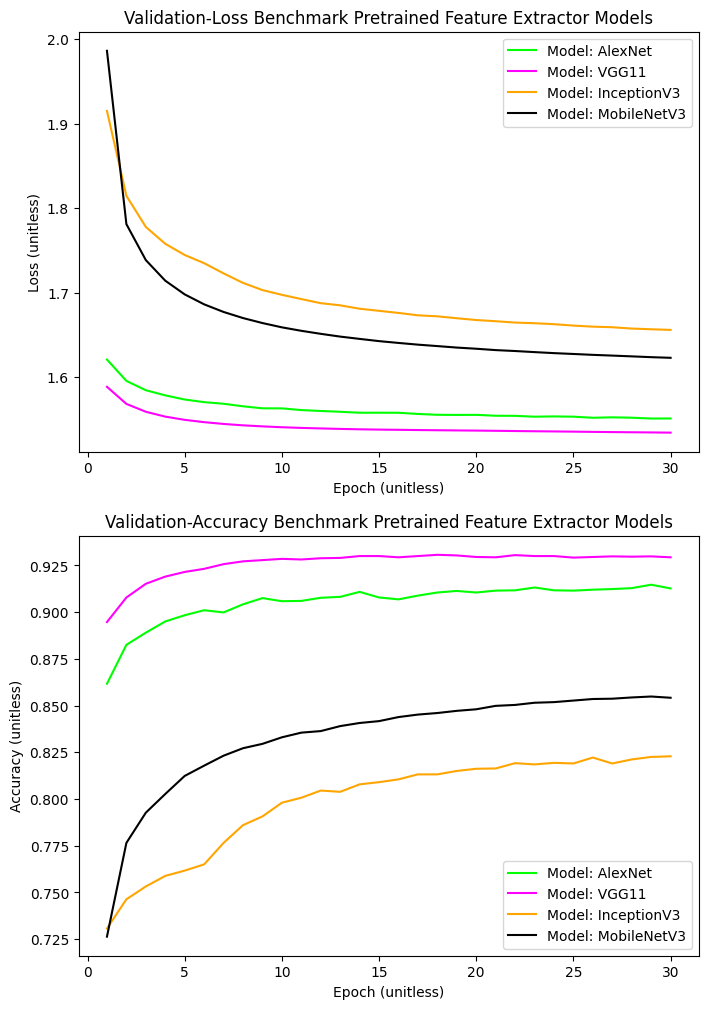

In [235]:
fig, ax = plt.subplots(2,1, figsize=(8, 12))
color1 = mcolors.CSS4_COLORS["lime"]
color2 = mcolors.CSS4_COLORS["magenta"]
color3 = mcolors.CSS4_COLORS["orange"]
color4 = mcolors.CSS4_COLORS["black"]

custom_ylim = (1.3,2.1)
custom_xlim = (1,30)

#plt.setp(ax,  ylim=custom_ylim)#, xlim=custom_xlim)




#---------------------------------- Loss ------------------------------------------------------------- #

ax[0].plot(df.index + 1,df["Validation","Alexnet_FE","Loss"],color = color1, label = "Model: AlexNet")
ax[0].plot(df.index + 1,df["Validation","VGG11_FE","Loss"],color = color2, label = "Model: VGG11")
ax[0].plot(df.index + 1,df["Validation","InceptionV3_FE","Loss"],color = color3, label = "Model: InceptionV3")
ax[0].plot(df.index + 1,df["Validation","MobileNetV3_FE","Loss"],color = color4, label = "Model: MobileNetV3")

ax[0].title.set_text("Validation-Loss Benchmark Pretrained Feature Extractor Models")
ax[0].set_xlabel("Epoch (unitless)")
ax[0].set_ylabel("Loss (unitless)")
ax[0].legend(loc='upper right')

#---------------------------------- Accuracy ------------------------------------------------------------- #

ax[1].plot(df.index + 1,df["Validation","Alexnet_FE","Accuracy"],color = color1, label = "Model: AlexNet")
ax[1].plot(df.index + 1,df["Validation","VGG11_FE","Accuracy"],color = color2, label = "Model: VGG11")
ax[1].plot(df.index + 1,df["Validation","InceptionV3_FE","Accuracy"],color = color3, label = "Model: InceptionV3")
ax[1].plot(df.index + 1,df["Validation","MobileNetV3_FE","Accuracy"],color = color4, label = "Model: MobileNetV3")

ax[1].title.set_text("Validation-Accuracy Benchmark Pretrained Feature Extractor Models")
ax[1].set_xlabel("Epoch (unitless)")
ax[1].set_ylabel("Accuracy (unitless)")
ax[1].legend(loc='lower right')


plt.show()

### Fine Tune Pretrained Models

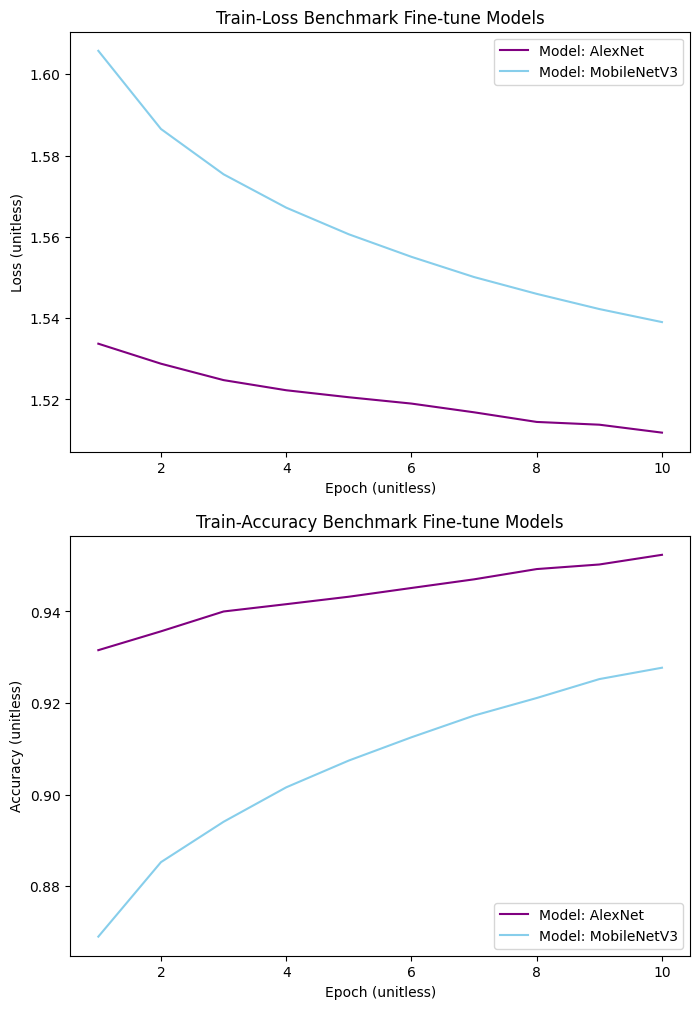

In [236]:
fig, ax = plt.subplots(2,1, figsize=(8, 12))
color1 = mcolors.CSS4_COLORS["purple"]
color2 = mcolors.CSS4_COLORS["skyblue"]


custom_ylim = (1.3,2.1)
custom_xlim = (1,30)

#plt.setp(ax,  ylim=custom_ylim)#, xlim=custom_xlim)




#---------------------------------- Loss ------------------------------------------------------------- #

ax[0].plot(df_worksheet_2.index + 1,df_worksheet_2["Train","Alexnet","Loss"],color = color1, label = "Model: AlexNet")
ax[0].plot(df_worksheet_2.index + 1,df_worksheet_2["Train","MobileNetV3","Loss"],color = color2, label = "Model: MobileNetV3")


ax[0].title.set_text("Train-Loss Benchmark Fine-tune Models")
ax[0].set_xlabel("Epoch (unitless)")
ax[0].set_ylabel("Loss (unitless)")
ax[0].legend(loc='upper right')

#---------------------------------- Accuracy ------------------------------------------------------------- #

ax[1].plot(df_worksheet_2.index + 1,df_worksheet_2["Train","Alexnet","Accuracy"],color = color1, label = "Model: AlexNet")
ax[1].plot(df_worksheet_2.index + 1,df_worksheet_2["Train","MobileNetV3","Accuracy"],color = color2, label = "Model: MobileNetV3")


ax[1].title.set_text("Train-Accuracy Benchmark Fine-tune Models")
ax[1].set_xlabel("Epoch (unitless)")
ax[1].set_ylabel("Accuracy (unitless)")
ax[1].legend(loc='lower right')


plt.show()

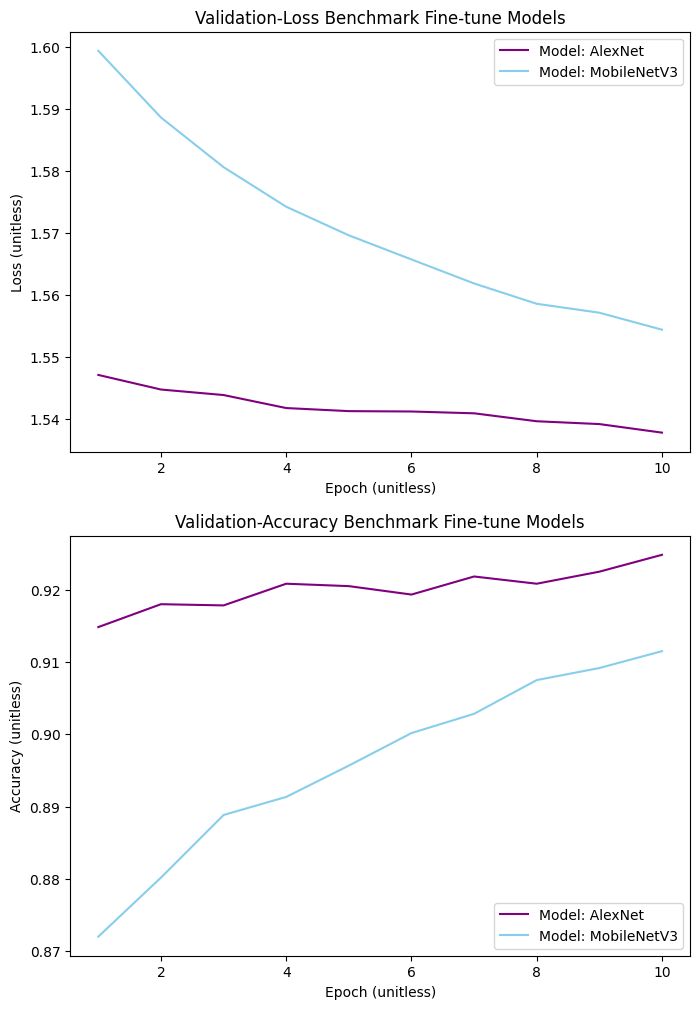

In [237]:
fig, ax = plt.subplots(2,1, figsize=(8, 12))
color1 = mcolors.CSS4_COLORS["purple"]
color2 = mcolors.CSS4_COLORS["skyblue"]


custom_ylim = (1.3,2.1)
custom_xlim = (1,30)

#plt.setp(ax,  ylim=custom_ylim)#, xlim=custom_xlim)




#---------------------------------- Loss ------------------------------------------------------------- #

ax[0].plot(df_worksheet_2.index + 1,df_worksheet_2["Validation","Alexnet","Loss"],color = color1, label = "Model: AlexNet")
ax[0].plot(df_worksheet_2.index + 1,df_worksheet_2["Validation","MobileNetV3","Loss"],color = color2, label = "Model: MobileNetV3")


ax[0].title.set_text("Validation-Loss Benchmark Fine-tune Models")
ax[0].set_xlabel("Epoch (unitless)")
ax[0].set_ylabel("Loss (unitless)")
ax[0].legend(loc='upper right')

#---------------------------------- Accuracy ------------------------------------------------------------- #

ax[1].plot(df_worksheet_2.index + 1,df_worksheet_2["Validation","Alexnet","Accuracy"],color = color1, label = "Model: AlexNet")
ax[1].plot(df_worksheet_2.index + 1,df_worksheet_2["Validation","MobileNetV3","Accuracy"],color = color2, label = "Model: MobileNetV3")


ax[1].title.set_text("Validation-Accuracy Benchmark Fine-tune Models")
ax[1].set_xlabel("Epoch (unitless)")
ax[1].set_ylabel("Accuracy (unitless)")
ax[1].legend(loc='lower right')


plt.show()

## Test Metrics

In [253]:
# Nombre del worksheet que deseas leer (reemplaza "NombreHoja" con el nombre real)
worksheet_name = "FE_Test"
pth = "./data.xlsx"

# Leer el archivo de Excel y seleccionar el worksheet específico
df = pd.read_excel(pth, sheet_name=worksheet_name,header=[0,1,2]).drop(["Unnamed: 0_level_0"],axis=1).drop(df.index[-1],axis=0)

C:\Users\kevin\AppData\Local\Temp\ipykernel_16532\2795769380.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = pd.read_excel(pth, sheet_name=worksheet_name,header=[0,1,2]).drop(["Unnamed: 0_level_0"],axis=1).drop(df.index[-1],axis=0)


In [255]:
df.tail()

Test                                       
   Alexnet_FE VGG11_FE InceptionV3_FE MobileNetV3_FE
     Accuracy Accuracy       Accuracy       Accuracy
95       0.93     0.95           0.85           0.85
96       0.88     0.94           0.79           0.85
97       0.95     0.96           0.88           0.90
98       0.97     0.99           0.91           0.91
99       0.87     0.91           0.81           0.83

In [262]:
# Nombre del worksheet que deseas leer (reemplaza "NombreHoja" con el nombre real)
worksheet_name = "FineTune_Test"
pth = "./data.xlsx"

# Leer el archivo de Excel y seleccionar el worksheet específico
df2 = pd.read_excel(pth, sheet_name=worksheet_name,header=[0,1,2]).drop(["Unnamed: 0_level_0"],axis=1).drop(df2.index[-1],axis=0)

C:\Users\kevin\AppData\Local\Temp\ipykernel_16532\4054131425.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df2 = pd.read_excel(pth, sheet_name=worksheet_name,header=[0,1,2]).drop(["Unnamed: 0_level_0"],axis=1).drop(df2.index[-1],axis=0)


In [263]:
df2.tail()

Test            
    Alexnet MobileNetV3
   Accuracy    Accuracy
95     0.95        0.92
96     0.90        0.90
97     0.95        0.95
98     0.97        0.97
99     0.91        0.89

### Adjusting pretrained model to Fashion MNIST output layer

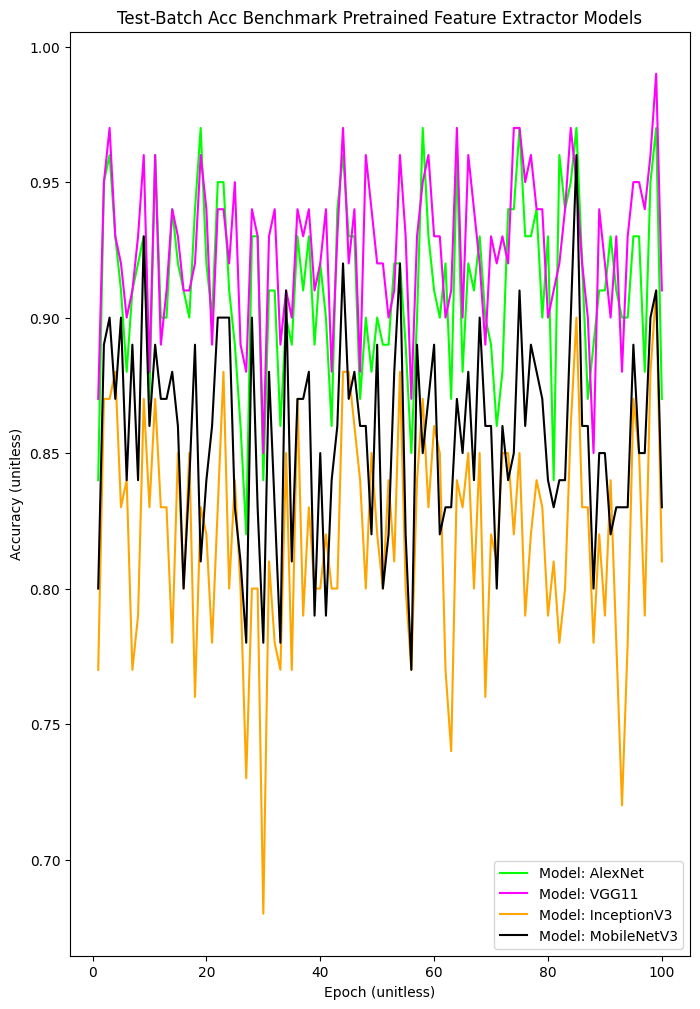

In [267]:
fig, ax = plt.subplots(1,1, figsize=(8, 12))
color1 = mcolors.CSS4_COLORS["lime"]
color2 = mcolors.CSS4_COLORS["magenta"]
color3 = mcolors.CSS4_COLORS["orange"]
color4 = mcolors.CSS4_COLORS["black"]

custom_ylim = (1.3,2.1)
custom_xlim = (1,30)

#plt.setp(ax,  ylim=custom_ylim)#, xlim=custom_xlim)




#---------------------------------- Accuracy ------------------------------------------------------------- #

ax.plot(df.index + 1,df["Test","Alexnet_FE","Accuracy"],color = color1, label = "Model: AlexNet")
ax.plot(df.index + 1,df["Test","VGG11_FE","Accuracy"],color = color2, label = "Model: VGG11")
ax.plot(df.index + 1,df["Test","InceptionV3_FE","Accuracy"],color = color3, label = "Model: InceptionV3")
ax.plot(df.index + 1,df["Test","MobileNetV3_FE","Accuracy"],color = color4, label = "Model: MobileNetV3")

ax.title.set_text("Test-Batch Acc Benchmark Pretrained Feature Extractor Models")
ax.set_xlabel("Epoch (unitless)")
ax.set_ylabel("Accuracy (unitless)")
ax.legend(loc='lower right')




plt.show()

### Fine Tune Pretrained Models

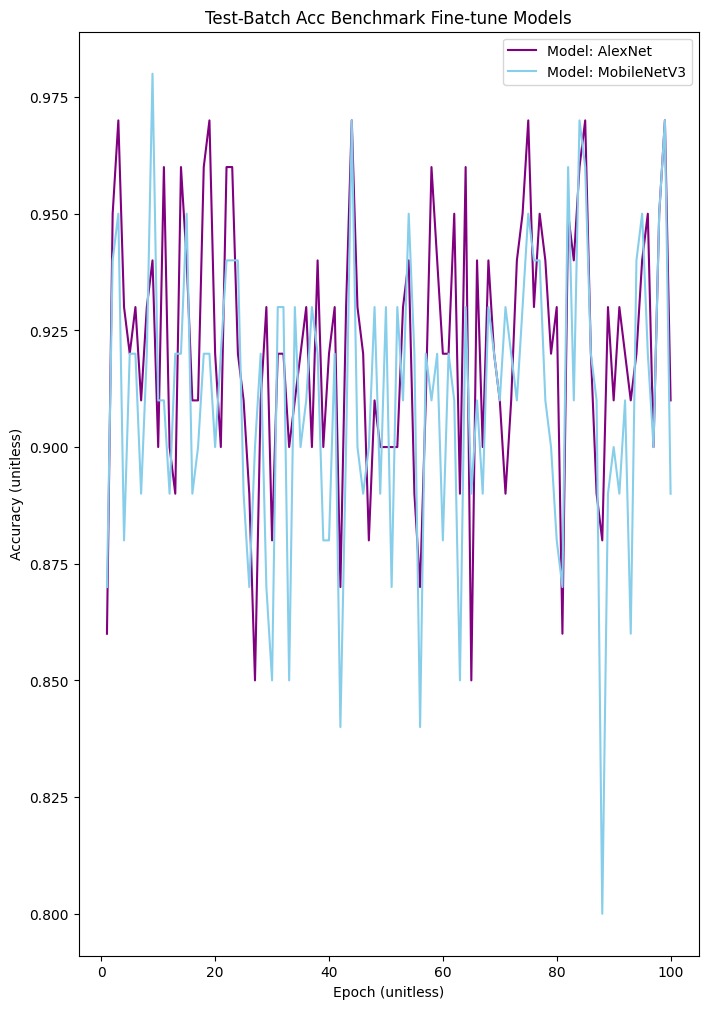

In [266]:
fig, ax = plt.subplots(1,1, figsize=(8, 12))
color1 = mcolors.CSS4_COLORS["purple"]
color2 = mcolors.CSS4_COLORS["skyblue"]


custom_ylim = (1.3,2.1)
custom_xlim = (1,30)

#plt.setp(ax,  ylim=custom_ylim)#, xlim=custom_xlim)




#---------------------------------- Accuracy ------------------------------------------------------------- #

ax.plot(df2.index + 1,df2["Test","Alexnet","Accuracy"],color = color1, label = "Model: AlexNet")
ax.plot(df2.index + 1,df2["Test","MobileNetV3","Accuracy"],color = color2, label = "Model: MobileNetV3")


ax.title.set_text("Test-Batch Acc Benchmark Fine-tune Models")
ax.set_xlabel("Epoch (unitless)")
ax.set_ylabel("Accuracy (unitless)")
ax.legend(loc='upper right')




plt.show()